In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Sun Feb 11 18:35:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:19:00.0 Off |                  Off |
| 39%   68C    P2             238W / 450W |  21010MiB / 24564MiB |     68%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Model Parts

In [3]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.uniform_prior import Prior
from model.latent.bottleneck_swae_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 256
hp.h_dims = [32, 64, 128, 256, 512]
hp.M = None
hp.N = 256
hp.z_activation = F.tanh

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 7.989990234375
encoder.convs 5.989013671875
encoder.linear 2.0009765625
prior 0.0
latent 0.0
decoder 8.028697967529297
decoder.linear 2.0078125
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train02.11-5/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 99600
-rw-rw-r-- 1 scpark scpark  1056110  2월 11 18:35 events.out.tfevents.1707643394.scpark-X299-WU8
-rw-rw-r-- 1 scpark scpark 50467924  2월 11 18:34 save_10000
-rw-rw-r-- 1 scpark scpark 50462060  2월 11 18:23 save_0


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=hp.N, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


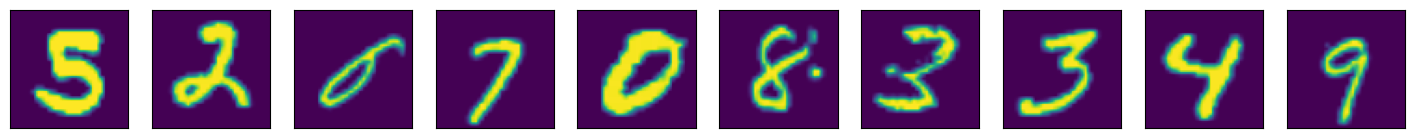

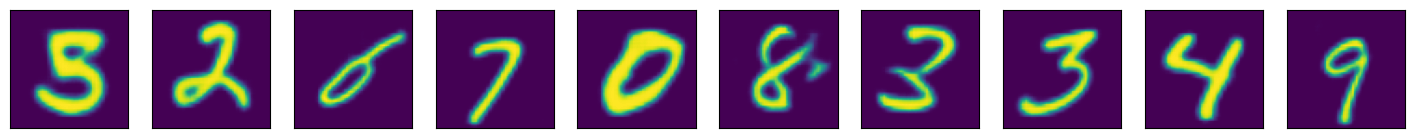

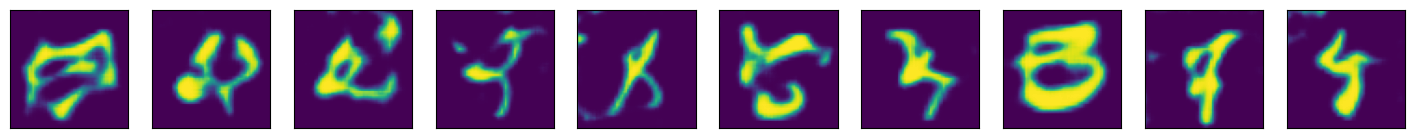

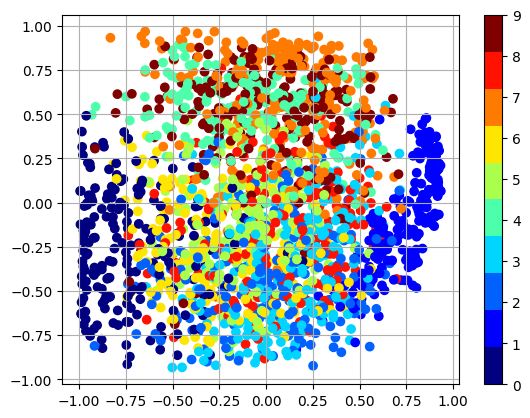

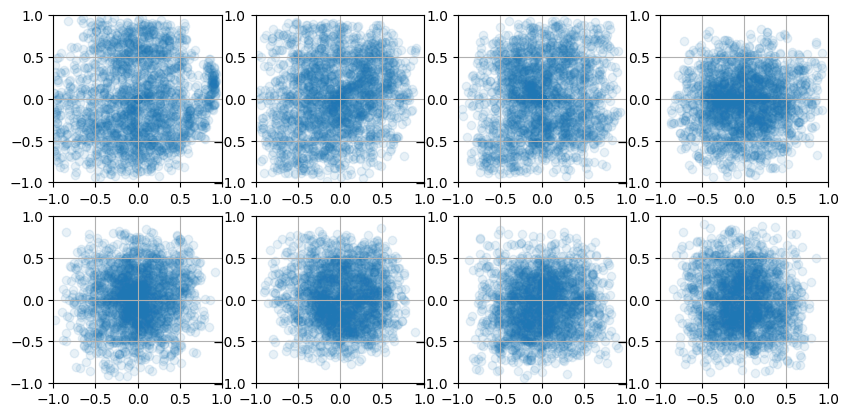

8001
swae_loss 0.013703584671020508
recon_loss 0.014575712382793427
8002
swae_loss 0.013046248815953732
recon_loss 0.0124598927795887
8003
swae_loss 0.012312531471252441
recon_loss 0.012909076176583767
8004
swae_loss 0.012686405330896378
recon_loss 0.012162602506577969
8005
swae_loss 0.01367275696247816
recon_loss 0.01267240196466446
8006
swae_loss 0.013449124991893768
recon_loss 0.018596328794956207
8007
swae_loss 0.012802522629499435
recon_loss 0.010696297511458397
8008
swae_loss 0.011797363869845867
recon_loss 0.013465343043208122
8009
swae_loss 0.012354716658592224
recon_loss 0.014081871137022972
8010
swae_loss 0.010683061555027962
recon_loss 0.012546291574835777
8011
swae_loss 0.013550922274589539
recon_loss 0.014232567511498928
8012
swae_loss 0.012927171774208546
recon_loss 0.013382806442677975
8013
swae_loss 0.013975164853036404
recon_loss 0.012112322263419628
8014
swae_loss 0.012429607100784779
recon_loss 0.014939602464437485
8015
swae_loss 0.011998291127383709
recon_loss 0.012

8124
swae_loss 0.011997802183032036
recon_loss 0.01247879397124052
8125
swae_loss 0.012703527696430683
recon_loss 0.011965124867856503
8126
swae_loss 0.011826288886368275
recon_loss 0.01108318381011486
8127
swae_loss 0.011710254475474358
recon_loss 0.016712728887796402
8128
swae_loss 0.012473057024180889
recon_loss 0.01691298745572567
8129
swae_loss 0.012391626834869385
recon_loss 0.014952896162867546
8130
swae_loss 0.011843206360936165
recon_loss 0.013026888482272625
8131
swae_loss 0.011921534314751625
recon_loss 0.012352163903415203
8132
swae_loss 0.012849630787968636
recon_loss 0.013439971953630447
8133
swae_loss 0.01098038163036108
recon_loss 0.014384637586772442
8134
swae_loss 0.011526921764016151
recon_loss 0.01451253890991211
8135
swae_loss 0.012125885114073753
recon_loss 0.016705036163330078
8136
swae_loss 0.010786611586809158
recon_loss 0.018128693103790283
8137
swae_loss 0.014043276198208332
recon_loss 0.01227828674018383
8138
swae_loss 0.012005643919110298
recon_loss 0.01325

swae_loss 0.013606353662908077
recon_loss 0.016278289258480072
8247
swae_loss 0.01139071211218834
recon_loss 0.01454862765967846
8248
swae_loss 0.012856919318437576
recon_loss 0.012667722068727016
8249
swae_loss 0.01408893521875143
recon_loss 0.016477838158607483
8250
swae_loss 0.014993846416473389
recon_loss 0.013752760365605354
8251
swae_loss 0.012641547247767448
recon_loss 0.014023752883076668
8252
swae_loss 0.01163570862263441
recon_loss 0.01550434809178114
8253
swae_loss 0.012630547396838665
recon_loss 0.013144361786544323
8254
swae_loss 0.01125354040414095
recon_loss 0.01235141884535551
8255
swae_loss 0.012135302647948265
recon_loss 0.015784047544002533
8256
swae_loss 0.011326487176120281
recon_loss 0.015855930745601654
8257
swae_loss 0.01264561153948307
recon_loss 0.013003985397517681
8258
swae_loss 0.011743261478841305
recon_loss 0.01184744294732809
8259
swae_loss 0.014093851670622826
recon_loss 0.01018291711807251
8260
swae_loss 0.011001436039805412
recon_loss 0.01261235028505

swae_loss 0.011771705001592636
recon_loss 0.013314884155988693
8371
swae_loss 0.011460120789706707
recon_loss 0.01492241770029068
8372
swae_loss 0.010776979848742485
recon_loss 0.014100390486419201
8373
swae_loss 0.010839157737791538
recon_loss 0.013258276507258415
8374
swae_loss 0.012079845182597637
recon_loss 0.012305960059165955
8375
swae_loss 0.0107711311429739
recon_loss 0.013122454285621643
8376
swae_loss 0.01174322608858347
recon_loss 0.014617560431361198
8377
swae_loss 0.01197455357760191
recon_loss 0.014045782387256622
8378
swae_loss 0.010909230448305607
recon_loss 0.01398506574332714
8379
swae_loss 0.013927805237472057
recon_loss 0.014197569340467453
8380
swae_loss 0.013413073495030403
recon_loss 0.0147257000207901
8381
swae_loss 0.012459973804652691
recon_loss 0.012476721778512001
8382
swae_loss 0.012051059864461422
recon_loss 0.011954039335250854
8383
swae_loss 0.011616120114922523
recon_loss 0.013853346928954124
8384
swae_loss 0.010503318160772324
recon_loss 0.012126035988

swae_loss 0.011005410924553871
recon_loss 0.012546065263450146
8494
swae_loss 0.012840037234127522
recon_loss 0.014629739336669445
8495
swae_loss 0.011302639730274677
recon_loss 0.01403125375509262
8496
swae_loss 0.011527538299560547
recon_loss 0.016165858134627342
8497
swae_loss 0.010492219589650631
recon_loss 0.010954566299915314
8498
swae_loss 0.012252995744347572
recon_loss 0.012990388087928295
8499
swae_loss 0.012396983802318573
recon_loss 0.014911100268363953
8500
swae_loss 0.013811052776873112
recon_loss 0.01662924885749817
8501
swae_loss 0.011230802163481712
recon_loss 0.012169811874628067
8502
swae_loss 0.012879465706646442
recon_loss 0.012020019814372063
8503
swae_loss 0.013307522051036358
recon_loss 0.009660030715167522
8504
swae_loss 0.012725870124995708
recon_loss 0.014514045789837837
8505
swae_loss 0.013575839810073376
recon_loss 0.014632339589297771
8506
swae_loss 0.011769431643188
recon_loss 0.01659298688173294
8507
swae_loss 0.010769907385110855
recon_loss 0.0086317816

8617
swae_loss 0.013166617602109909
recon_loss 0.011525201611220837
8618
swae_loss 0.012157742865383625
recon_loss 0.014223932288587093
8619
swae_loss 0.011385289020836353
recon_loss 0.012379860505461693
8620
swae_loss 0.01315486989915371
recon_loss 0.01699226349592209
8621
swae_loss 0.011384270153939724
recon_loss 0.010502614080905914
8622
swae_loss 0.013293762691318989
recon_loss 0.012330341152846813
8623
swae_loss 0.011345922946929932
recon_loss 0.011020737700164318
8624
swae_loss 0.012222210876643658
recon_loss 0.011124230921268463
8625
swae_loss 0.011424283497035503
recon_loss 0.013447677716612816
8626
swae_loss 0.012098104692995548
recon_loss 0.013005661778151989
8627
swae_loss 0.01050865463912487
recon_loss 0.011905397288501263
8628
swae_loss 0.01119082048535347
recon_loss 0.013333549723029137
8629
swae_loss 0.011622513644397259
recon_loss 0.012794177047908306
8630
swae_loss 0.012852725572884083
recon_loss 0.013795197010040283
8631
swae_loss 0.01188694965094328
recon_loss 0.0159

8741
swae_loss 0.01293930783867836
recon_loss 0.011148634366691113
8742
swae_loss 0.011539077386260033
recon_loss 0.017811089754104614
8743
swae_loss 0.012796400114893913
recon_loss 0.010075166821479797
8744
swae_loss 0.01256943866610527
recon_loss 0.01422572135925293
8745
swae_loss 0.016184698790311813
recon_loss 0.014022327959537506
8746
swae_loss 0.012629246339201927
recon_loss 0.013925688341259956
8747
swae_loss 0.013345782645046711
recon_loss 0.0145315146073699
8748
swae_loss 0.010724741965532303
recon_loss 0.012745842337608337
8749
swae_loss 0.013410556130111217
recon_loss 0.015155162662267685
8750
swae_loss 0.012454220093786716
recon_loss 0.011835405603051186
8751
swae_loss 0.010062679648399353
recon_loss 0.013773303478956223
8752
swae_loss 0.01311472523957491
recon_loss 0.011632397770881653
8753
swae_loss 0.010776879265904427
recon_loss 0.015326295047998428
8754
swae_loss 0.011866750195622444
recon_loss 0.012952986173331738
8755
swae_loss 0.012755000032484531
recon_loss 0.01719

swae_loss 0.010742861777544022
recon_loss 0.014092987403273582
8864
swae_loss 0.01130314078181982
recon_loss 0.014890062622725964
8865
swae_loss 0.012359730899333954
recon_loss 0.013206425122916698
8866
swae_loss 0.01400926522910595
recon_loss 0.010916655883193016
8867
swae_loss 0.012533802539110184
recon_loss 0.011612718924880028
8868
swae_loss 0.011279558762907982
recon_loss 0.013969535939395428
8869
swae_loss 0.011959372088313103
recon_loss 0.012813899666070938
8870
swae_loss 0.009373430162668228
recon_loss 0.012497722171247005
8871
swae_loss 0.010191772133111954
recon_loss 0.017443299293518066
8872
swae_loss 0.01069576758891344
recon_loss 0.01442230399698019
8873
swae_loss 0.012285599485039711
recon_loss 0.013371391221880913
8874
swae_loss 0.012693223543465137
recon_loss 0.014659151434898376
8875
swae_loss 0.011624226346611977
recon_loss 0.013479312881827354
8876
swae_loss 0.01268197875469923
recon_loss 0.013084310106933117
8877
swae_loss 0.011611256748437881
recon_loss 0.013244251


KeyboardInterrupt



In [10]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=hp.M)

            # Backward
            loss = 0
            for key in data.keys():
                if 'kl_loss' in key:
                    loss = loss + data[key] * 0.00025
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                        
                elif 'wise_min_loss' in key:
                    loss = loss + data[key] * 1e+4
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=hp.M)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = (torch.rand(10, hp.z_dim)*2-1).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
            
            _z = data['z'].data.cpu().numpy()

            plt.figure(figsize=[10, 10])
            for i in range(8):
                plt.subplot(4, 4, i+1)
                plt.scatter(_z[:, i*2], _z[:, i*2+1], alpha=0.1)
                plt.grid()
                plt.xlim([-1, 1])
                plt.ylim([-1, 1])

            plt.show()
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

In [ ]:
plt.figure(figsize=[10, 10])
for i in range(8):
    plt.subplot(4, 4, i+1)
    plt.scatter(_z[:, i*2], _z[:, i*2+1], alpha=0.1)
    plt.grid()
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    
plt.show()